In [8]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pylab as plt
import seaborn as sns

bn = 'woundhealing-v2-mix+Fwoundhealing+roi48_unet-simple_maxlikelihood_20190719_021908_adam_lr0.000256_wd0.0_batch256'
#results_dir = Path.home() / 'workspace/localization/predictions/woundhealing' / bn
results_dir =  Path.home() / 'OneDrive - Nexus365/heba/WoundHealing/predictions/' / bn
#results_dir =  Path.home() / 'OneDrive - Nexus365/heba/WoundHealing/predictions/' / bn
src_file = save_name = results_dir / 'cell_density_data.p'

with open(src_file, 'rb') as fid:
    data = pickle.load(fid)
    
data_info = data['data_info']
cell_densities_from_wound = data['cell_densities_from_wound']
dist_from_wound = data['dist_from_wound']

#Control (mock treatment so here our baseline)
#Control (no treatment)
#CDC42 gene KD (this one affect migration): D01 and D12
#CDH5 gene KD (this one affect cell-cell contact): E01 and E12


#%%
data_ctr = data_info[data_info['condition'] != 'unknown']


/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


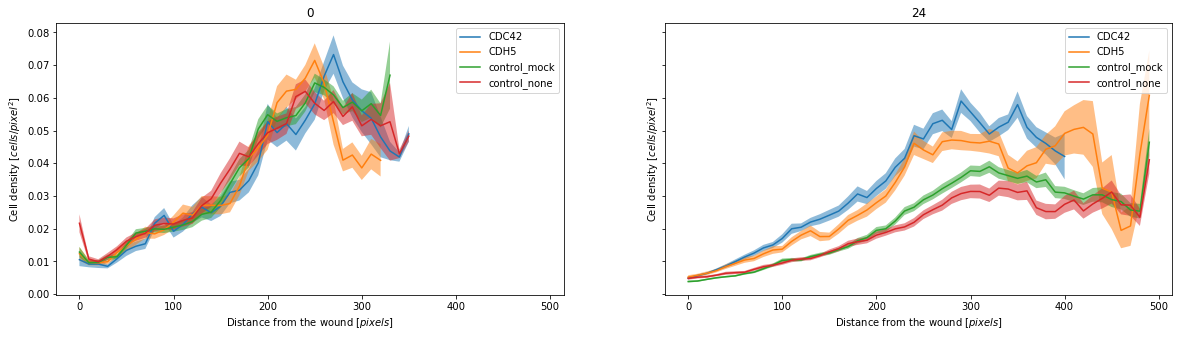

In [9]:
fig, axs = plt.subplots(1, 2,sharex = True, sharey = True, figsize = (20, 5))
for ax, (exp_time, exp_dat) in zip(axs, data_ctr.groupby('time_point')):

    
    for treatment, res in exp_dat.groupby('condition'):
        dists = cell_densities_from_wound[res.index]

        n_valid = np.sum(~np.isnan(dists), axis=0)
        yy = np.nanmean(dists, axis=0)
        yy[n_valid<3] = np.nan 
        
        err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)
        
        ax.plot(dist_from_wound, yy, label = treatment)
        ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)
        
    ax.legend()
    ax.set_title(exp_time)
    ax.set_xlabel('Distance from the wound [$pixels$]')
    ax.set_ylabel('Cell density [$cells/pixel^{2}$]')

/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


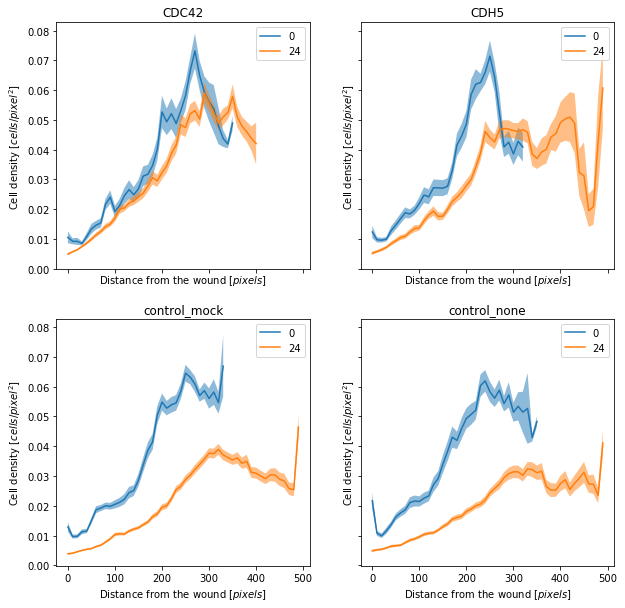

In [10]:
fig, axs = plt.subplots(2, 2,sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
for ax, (treatment, exp_dat) in zip(axs, data_ctr.groupby('condition')):

    
    for exp_time, res in exp_dat.groupby('time_point'):
        dists = cell_densities_from_wound[res.index]

        n_valid = np.sum(~np.isnan(dists), axis=0)
        yy = np.nanmean(dists, axis=0)
        yy[n_valid<3] = np.nan 
        
        err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)
        
        ax.plot(dist_from_wound, yy, label = exp_time)
        ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)
        
    ax.legend()
    ax.set_title(treatment)
    ax.set_xlabel('Distance from the wound [$pixels$]')
    ax.set_ylabel('Cell density [$cells/pixel^{2}$]')

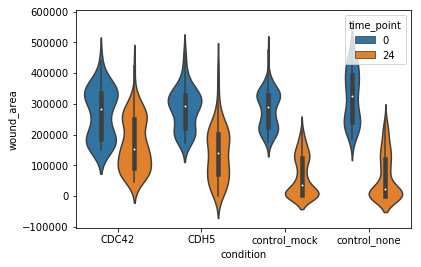

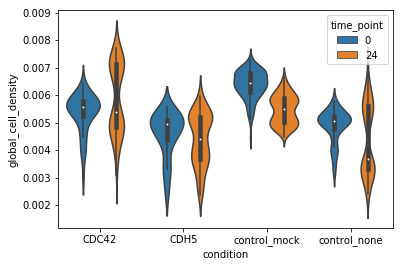

In [11]:
order = [ 'CDC42', 'CDH5', 'control_mock', 'control_none']
plt.figure()
sns.violinplot(x="condition", y="wound_area", hue="time_point", data = data_ctr, order = order)

plt.figure()
sns.violinplot(x="condition", y="global_cell_density", hue="time_point", data = data_ctr, order = order)


(317, 8)


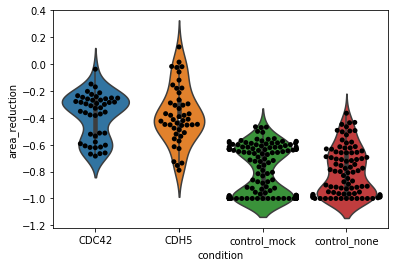

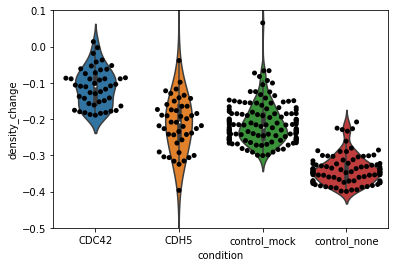

In [15]:
area_changes = []
density_changes = []

densities = []

for key, dat in data_ctr.groupby(['plate_id', 'well_id']):
    assert len(dat)  <= 2
    if len(dat) == 2:
        dd = dat.sort_values(by = 'time_point').copy()
        
        before_row = dd.iloc[0]
        after_row = dd.iloc[1]
        assert before_row['time_point'] == 0
        assert after_row['time_point'] == 24
        
        row = (*before_row[['plate_id', 'condition']], 
               before_row['wound_area'], 
               after_row['wound_area'], 
               (after_row['wound_area'] - before_row['wound_area'])/before_row['wound_area'],
               before_row['global_cell_density'], 
               after_row['global_cell_density'], 
               (after_row['global_cell_density'] - before_row['global_cell_density'])/before_row['global_cell_density'],
              ) 
        area_changes.append(row)
        
        #density_changes.append(densities[1]/densities[0])
        densities.append(cell_densities_from_wound[dd.index])
        
        
area_changes = pd.DataFrame(area_changes, columns = ['plate_id', 
                                                     'condition', 
                                                     'area_t0', 
                                                     'area_t24', 
                                                     'area_reduction',
                                                     'cell_density_t0',
                                                     'cell_density_t24',
                                                     'density_change',
                                                     ])

densities = np.array(densities)




plt.figure()
sns.violinplot(x="condition", y="area_reduction", data = area_changes, order = order)
sns.swarmplot(x="condition", y="area_reduction", color = 'k', data = area_changes, order = order)


plt.figure()
sns.violinplot(x="condition", y="density_change", data = area_changes, order = order)
sns.swarmplot(x="condition", y="density_change", color = 'k', data = area_changes, order = order)
plt.ylim(-0.5, 0.1)

print(area_changes.shape)


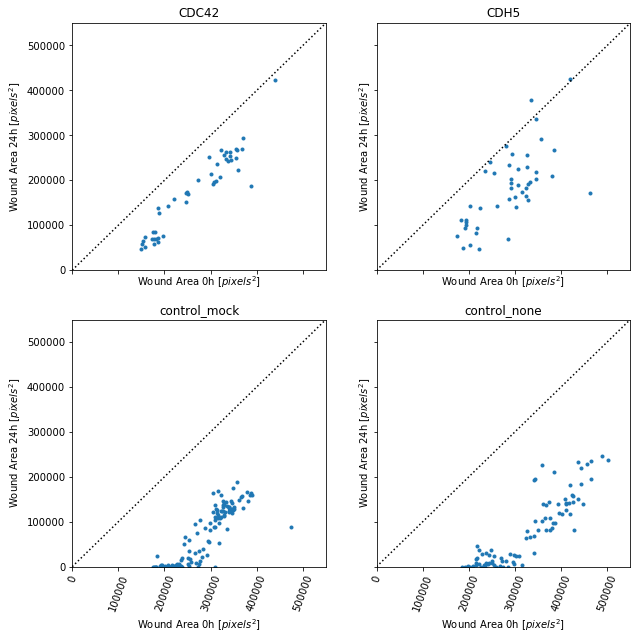

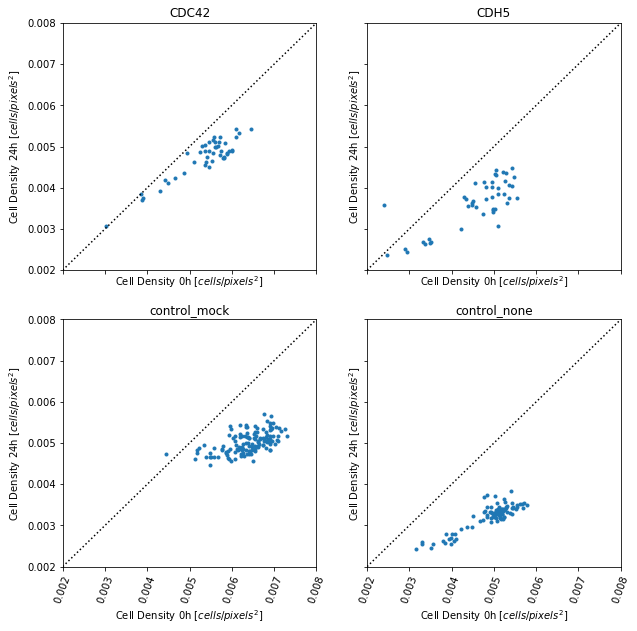

In [16]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
lims = [0, 55e4]
for ax, (treatment, info) in zip(axs, area_changes.groupby(['condition'])):
    ax.plot(info['area_t0'], info['area_t24'], '.')
    
    ax.set_title(treatment)
    ax.set_xlabel('Wound Area 0h [$pixels ^2$]')
    ax.set_ylabel('Wound Area 24h [$pixels ^2$]')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
    
    ax.plot(lims, lims, ':k')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
lims = [2e-3, 8e-3]
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
for ax, (treatment, info) in zip(axs, area_changes.groupby(['condition'])):
    ax.plot(info['cell_density_t0'], info['cell_density_t24'], '.')
    
    ax.set_title(treatment)
    ax.set_xlabel('Cell Density 0h [$cells/pixels ^2$]')
    ax.set_ylabel('Cell Density 24h [$cells/pixels ^2$]')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
    
    ax.plot(lims, lims, ':k')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    

/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


Text(0,0.5,'Cell density [$cells/pixel^{2}$]')

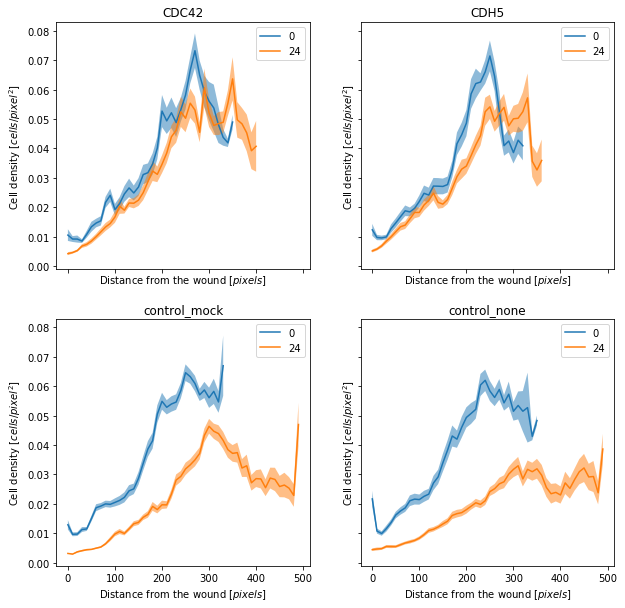

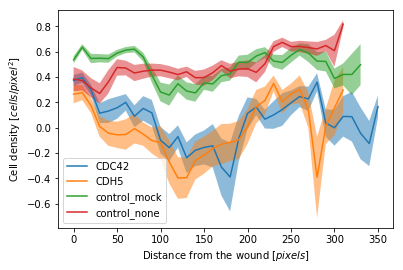

In [17]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
for ax, (treatment, info) in zip(axs, area_changes.groupby(['condition'])):
    dat = densities[info.index]
    for ii, exp_time in enumerate([0, 24]):
        dists = dat[:, ii]
        n_valid = np.sum(~np.isnan(dists), axis=0)
        yy = np.nanmean(dists, axis=0)
        yy[n_valid<3] = np.nan 

        err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)

        ax.plot(dist_from_wound, yy, label = exp_time)
        ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)

    ax.legend()
    ax.set_title(treatment)
    ax.set_xlabel('Distance from the wound [$pixels$]')
    ax.set_ylabel('Cell density [$cells/pixel^{2}$]')



fig, ax = plt.subplots(1, 1)
for (treatment, info) in area_changes.groupby(['condition']):
    dat = densities[info.index]
    dists = (dat[:, 0] - dat[:, 1])/dat[:, 0]
    
    
    n_valid = np.sum(~np.isnan(dists), axis=0)
    yy = np.nanmean(dists, axis=0)
    yy[n_valid<3] = np.nan 

    err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)

    ax.plot(dist_from_wound, yy, label = treatment)
    ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)
    

ax.legend()
ax.set_xlabel('Distance from the wound [$pixels$]')
ax.set_ylabel('Cell density [$cells/pixel^{2}$]')